<a href="https://colab.research.google.com/github/norgel/Analysis-of-Stroke-Patients/blob/main/Patient_Analysis_of_Stroke_Pre_Post_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Nicholas Orgel

Date Started: 11/02/2022

Last Editorial Date: 11/17/2022

Dataset Aquired from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

- This is a classification dataset that has the task of identifying whether or not a person has had a stroke.
---
## **Description:**
- Excerpt from the dataset description: "According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient."

---

## **Tasks:**

- Deleted unnecessay columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
- Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

---

#**Data Dictionary**


Column Name | Description
---|---
id | Unique identifier
gender| 'Male', 'Female', or 'Other'
age| Age of the patient
hypertension | 0 if patient doesn't have hypertension, 1 if the patient has hypertension
ever_married | 'No' or 'Yes'
work_type | 'children', 'govt_job', 'never_worked', 'private', or 'self-employed'
Residence_type | 'Rural' or 'Urban'
avg_glucose_level | average glucose level in blood
bmi | body mass index
smoking_status | 'formerly smoke', 'never smoked', 'smokes', or 'unknown'
stroke | 1 if the patient had a stroke or 0 if not

## **Import Libraries**

In [1]:
# Main Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Pipeline Display
from sklearn import set_config
set_config(display='diagram')

## **Load Dataset Head**

In [2]:
# Load the baseline dataset
data = '/content/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(data)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# Showing names of columns and shape of dataset
display(df.columns)
print(df.shape)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

(5110, 12)


This is the list of columns that are present in the dataset. In my opinion, the 'id' column is not needed because it is vague and not categorized in a way that can be compared to the other columns.

In the current dataset that is present, there is `5,110 rows and 12 columns`. This will be reduced to 11 columns because `'id'` is an unnecessary column.

---

I will make a copy of the data in order to enact all the changes.

### **Data Copy**

In [4]:
# Make a copy of the base dataset that is used for changes.
exp_df = df.copy()
ml_df = df.copy()

In [5]:
# Delete the unnecessary 'id' column from both copies of the original dataset (exp_df & ml_df)
exp_df = exp_df.drop(columns='id', axis=1)
ml_df = ml_df.drop(columns='id', axis=1)
exp_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
# Checking for duplicates in the dataset
exp_df.duplicated().sum()

0

In [7]:
# Checking for missing values in the dataset
exp_df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are **no duplicates** present in the dataset, but there is **201 missing values in the 'bmi'** column.

In [8]:
# Checking the datatypes present
exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


There is **3 float datatypes**, **3 integer datatypes**, and **5 object datatypes**.

---

### **Identify Categorical Values**

In [9]:
# Identifying values for gender column
exp_df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [10]:
# Removing 'Other' from gender column
exp_df = exp_df[~(exp_df['gender']=='Other')]

In [11]:
# Ordinal Encoding
exp_df['gender'].replace({'Female': 0,
                         'Male': 1}, inplace=True)

In [12]:
exp_df['gender'].value_counts()

0    2994
1    2115
Name: gender, dtype: int64

There seems to be no inconsistencies with this column.

---

In [13]:
exp_df['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

There is a lot of inconsistencies and outliers in this data column. It can be better visualized in a boxplot.

Some values, like **0.08 do not make sense**, this would make sense if it were 8.00 years of age.

---

In [14]:
exp_df['hypertension'].value_counts()

0    4611
1     498
Name: hypertension, dtype: int64

There is no visible inconsistencies.
- 0 means the patient **does not have** hypertension.
- 1 means the patient **has** hypertension.
---

In [15]:
exp_df['heart_disease'].value_counts()

0    4833
1     276
Name: heart_disease, dtype: int64

There is no visible inconsistencies.
- 0 means the patient **does not have** heart disease.
- 1 means the patient **has** heart disease.
---

In [16]:
exp_df['ever_married'].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [17]:
exp_df['ever_married'].replace({'Yes':1, 'No':0}, inplace=True)

In [18]:
exp_df['ever_married'].value_counts()

1    3353
0    1756
Name: ever_married, dtype: int64

There is no visible inconsistencies.

- This column can be ordinal encoded.
---

In [19]:
exp_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [20]:
exp_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [21]:
exp_df['Residence_type'].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [22]:
exp_df['avg_glucose_level'].value_counts()

93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
94.07     1
111.93    1
94.40     1
95.57     1
85.28     1
Name: avg_glucose_level, Length: 3978, dtype: int64

In [23]:
exp_df['bmi'].value_counts()

28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: bmi, Length: 418, dtype: int64

In [24]:
exp_df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [25]:
exp_df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

- 0 means the patient has not had a stroke.
- 1 means the patient has had a stroke.

There is no visible inconsistencies.

---

# **Univariate Visualizations**

For target (y) and features (X)

- Target (y) is ['stroke']
- Features (X) are everything else.
---

#### **gender**

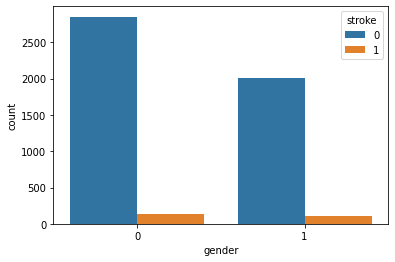

In [26]:
sns.countplot(x='gender', data=exp_df, hue='stroke');

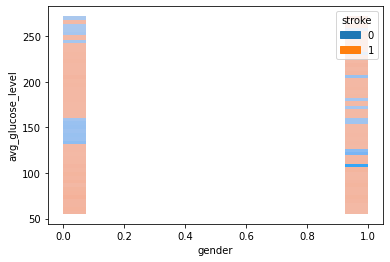

In [27]:
sns.histplot(x='gender', y= 'avg_glucose_level', data = exp_df, hue='stroke');

**Base Model**
- There is only a minimum line in the base gender boxplot for those whose gender is unknown or "other".

**Combined Model**
- You can see that there are numerous outliers on both the Male/Female genders around the 200 glucose level.

---

#### **age**

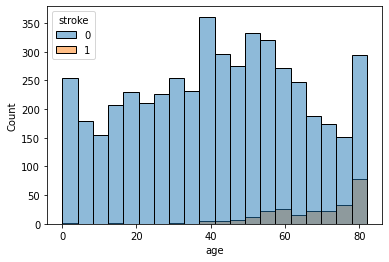

In [28]:

sns.histplot(x='age', data = exp_df, hue='stroke');

AxesSubplot(0.125,0.125;0.775x0.755)


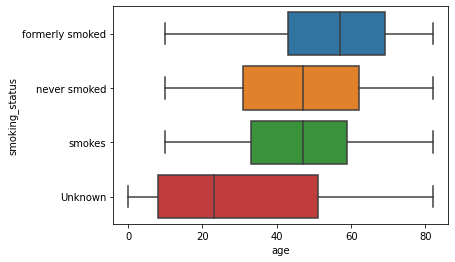

In [29]:
print(sns.boxplot(x='age', y='smoking_status', data = exp_df));

**Base Model**
- There are no outliers on the age column on it's own. 

**Combined Model**
- When tracking smoking status based on age. There is a larger majority of people that have formerly smoked around the ages of 40-70.

---

#### **hypertension**

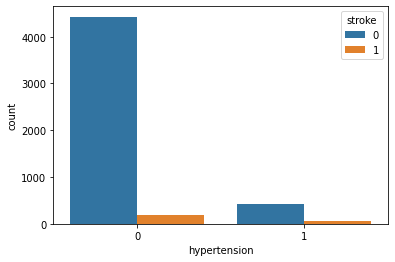

In [30]:
sns.countplot(x='hypertension', data=exp_df, hue='stroke');

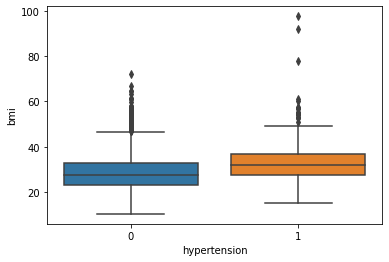

In [31]:
sns.boxplot(x='hypertension', y='bmi', data=exp_df);

**Base Model**
- In the base boxplot, the only outliers in the hypertension column are 1. Which is for patients that **do have hypertension**.

**Combined Model**
- In the boxplot that **compares 'hypertension' and 'bmi'**, there are bigger outliers for those that **do have hypertension with a BMI between 55-100**.

---

#### **heart_disease**

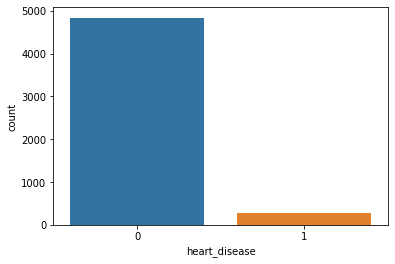

In [32]:
sns.countplot(x='heart_disease', data=exp_df);

In [33]:
exp_df['heart_disease'].value_counts()

0    4833
1     276
Name: heart_disease, dtype: int64

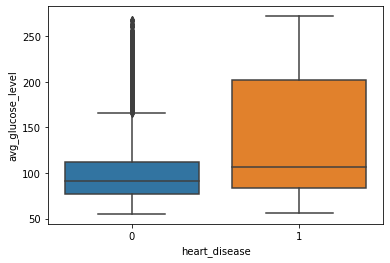

In [34]:
sns.boxplot(x='heart_disease', y='avg_glucose_level', data=exp_df);

**Base Model**
- In the base boxplot model, the only outliers are for those that do have heart disease.

**Combined Model**
- In the boxplot comparing heart disease and average glucose level. The only outliers are for patients that **did not have heart disease** & **had an avg. glucose level between 175-250**.

---

#### **ever_married**

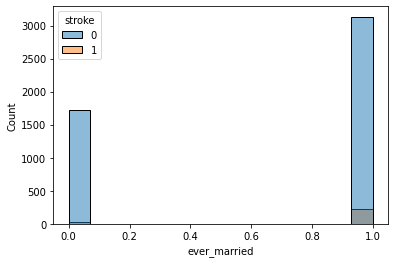

In [35]:
sns.histplot(x='ever_married', data=exp_df, hue='stroke');

**Base Model**
- In the base boxplot model, there is no outliers present.
---

#### **work_type**

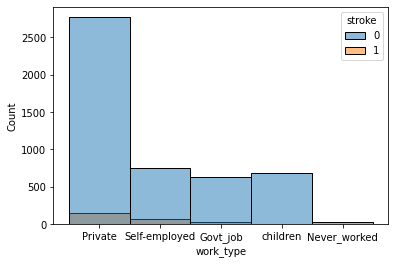

In [36]:
sns.histplot(x='work_type', data=exp_df, hue='stroke');

In [37]:
exp_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

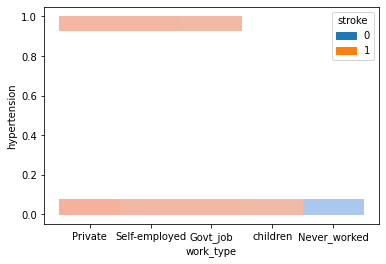

In [38]:
sns.histplot(x='work_type', y='hypertension', data=exp_df, hue='stroke');

**Base Model**
- There are no outliers

**Combined Model**
- There are outliers for people that **have hypertension** that work in either **the Private Sector (0), Self-employed (1), or work a Government Job (3).**

---

#### **Residence_type**

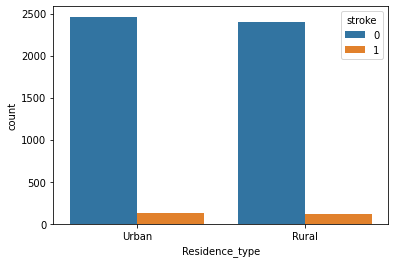

In [39]:
sns.countplot(x='Residence_type', data=exp_df, hue='stroke');

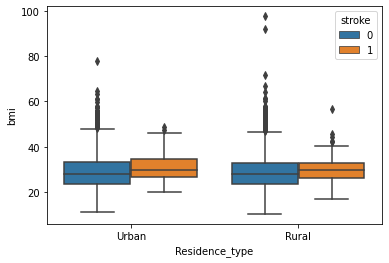

In [40]:
sns.boxplot(x='Residence_type', y='bmi',
            data=exp_df, hue='stroke');

**Base Model**
- There are no outliers present in the base model.

**Combined Model**
- In the combined model comparing Residence type and bmi, there are outliers present in both "Urban" and "Rural" residencies. But there appears to be more in the 'Rural' residence type.

---

#### **avg_glucose_level**

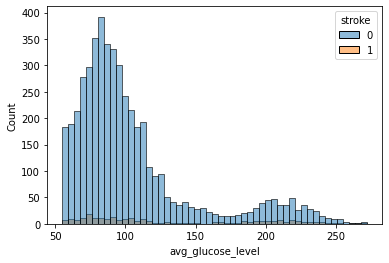

In [41]:
sns.histplot(x='avg_glucose_level', data=exp_df, hue='stroke');

**Base Model**
- There is a massive amount of outliers present after the average glucose level reaches around 160, and stretches past 250.

---

#### **bmi**

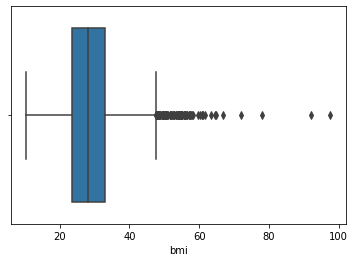

In [42]:
sns.boxplot(x='bmi', data=exp_df);

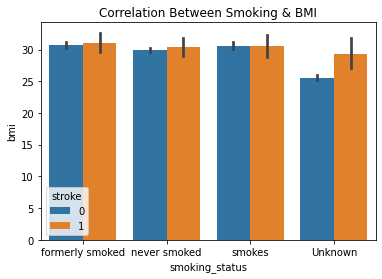

In [43]:
sns.barplot(x='smoking_status', y='bmi', data=exp_df, hue='stroke')
plt.title('Correlation Between Smoking & BMI');

**Base Model**
- In the base model, there are outliers present around the bmi mark of 45-50 and stretching to a bmi of 100.

**Combined Model**
- In the combined model of 'bmi' and 'smoking status', there are outliers present in all the different values of smoking status. These outliers all start around the bmi mark of 45-50.

---

#### **smoking_status**

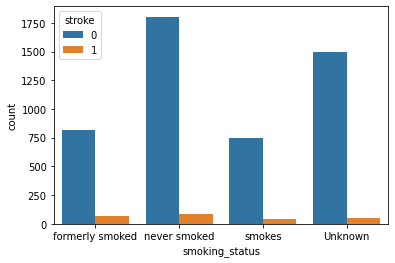

In [44]:
sns.countplot(x='smoking_status', data=exp_df, hue='stroke');

**Base Model**
- In the base model, there are no outliers present.

**Combined Model**
- In the combined model of 'smoking_status' and 'gender'. There are no outliers present, but there is only whiskers (**black line**) present in the smoking value of 'formerly smoked'.

---

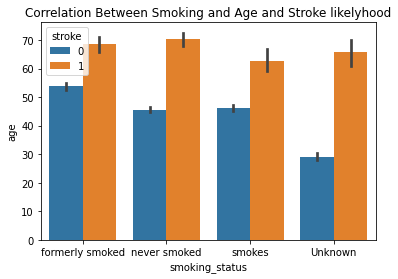

In [45]:
plt.title('Correlation Between Smoking and Age and Stroke likelyhood')
sns.barplot(x='smoking_status', y='age', data=exp_df, hue='stroke');

#### **stroke**

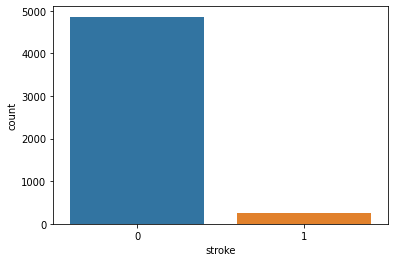

In [46]:
sns.countplot(x='stroke', data=exp_df);

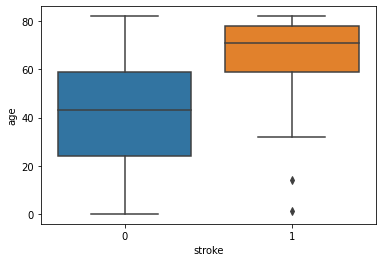

In [47]:
sns.boxplot(x='stroke', y='age', data=exp_df);

**Base Model**
- There are only outliers present in patients that have had a stroke.

**Combined Model**
- In the combined model of patients that have had a stroke and patients ages. There are only outliers present in patients that **have had a stroke and are between the ages of 20 and 0.**

---

#**Correlation Heatmap of Features and Target**

In [48]:
corr = exp_df.corr()

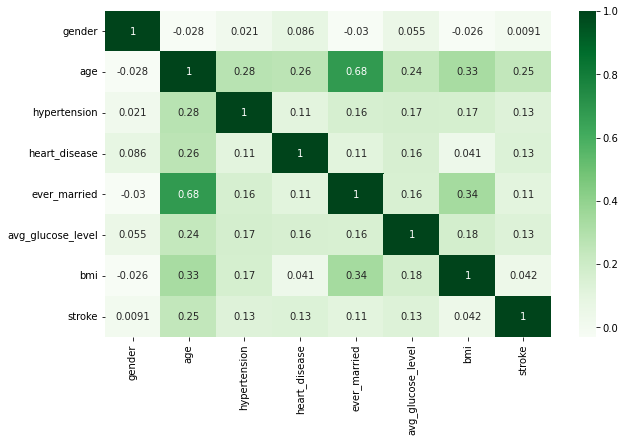

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(corr, cmap='Greens', annot=True);

**Medium Correlations** - There is a medium correlation between a patients' age and whether they've ever been married.

**Low Correlations** - There is a low correlation between a patients' age and their bmi. As well as a patients' bmi, and whether they've ever been married.

**Target and Features** - There is a **LOW** correlation between a patients' age and whether they've had a stroke.

**LinePlot Visualizations**

- **LinePlot 1** - Features *('age' & 'ever_married')*

- **LinePlot 2** - Target & Feature *('stroke' & 'age')*

#**Correlation/Multivariate Visualizations**

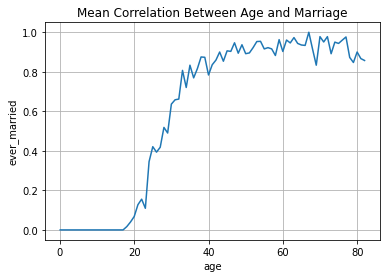

In [50]:
sns.lineplot(data=exp_df, x='age', y='ever_married', ci=None)
plt.title('Mean Correlation Between Age and Marriage')
plt.grid();

- People normally start to get married around 30 years of age.
- At around 65, nearly 100% of people are married.
- Many patients started to get married in their 20's and 30's with a larger number getting married as they got older.

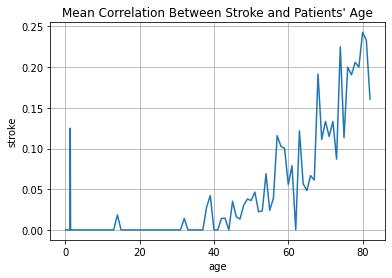

In [51]:
sns.lineplot(data=exp_df, x='age', y='stroke', ci=None)
plt.title("Mean Correlation Between Stroke and Patients' Age")
plt.grid();

- As the older a person gets their likelyhood of having a stroke increases.
- The most significant age where someone is likely to have a stroke is around age 80 with a 25% chance probability.
- While the lineplot gives the interpretation that infants are at high risk of a stroke, this is only from 13 values that are present in the age column that are less than 20 years of age. It has no significant impact on the risk at early developmental stages.

In [52]:
# Replacing numerical values in stroke column so visualizations are more clear.
string_dict = {0: 'No Stroke', 1: 'Stroke'}
exp_df['stroke'].replace(string_dict, inplace=True)

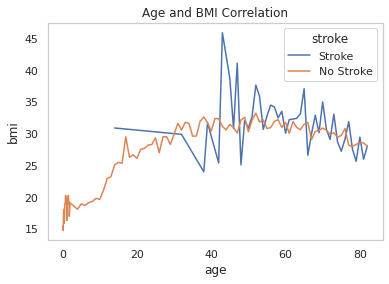

In [92]:
sns.lineplot(data = exp_df, x='age', y='bmi', ci=None, hue='stroke')
plt.title('Age and BMI Correlation')
plt.grid();

- The lineplot above shows that when comparing patient's age and bmi and the likelyhood of having a stroke; there seems to be no major significance as only a small minority of patients the age groups of 60-80 have had a stroke.

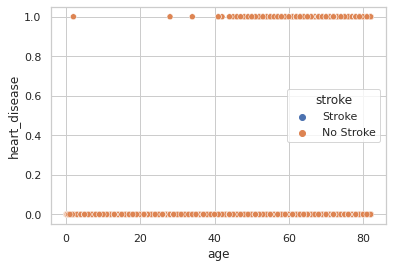

In [54]:
sns.set(style='whitegrid')

sns.scatterplot(x='age',
                y='heart_disease',
                hue='stroke',
                data=exp_df);

- There seems to be no major impact that heart disease has on a patients' age and their likelyhood of having a stroke.

In [55]:
# Checking number of patients that have a small age group to address in the lineplot
exp_df['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

In [56]:
# Checking if change worked
exp_df['stroke'].value_counts()

No Stroke    4860
Stroke        249
Name: stroke, dtype: int64

---
#**Data PreProcessing**



For Data Preprocessing / Machine Learning we will use the machine learning copy of the dataset provided labeled `ml_df`.

In [57]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


##**ID Vector & Features**

In [58]:
# The target for this dataset is stroke so that is dropped from X and assigned to y.
X = ml_df.drop(('stroke'), axis=1)
y = ml_df['stroke']

##**Validation Split**

In [59]:
# A validation split is made to prevent data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

##**Data Type Analysis**

In [60]:
#Datatype analysis
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


---
**Nominal Features**
- gender (object)
- hypertension (int64)
- heart_disease (int64)
- ever_married (object)
- work_type (object)
- Residence_type (object)
- smoking_status (object)

**Nominal Target**
- stroke (int64)

**Numerical Features**
- age (float64)
- avg_glucose_level (float64)
- bmi (float64)

---
In order to make column selectors, the nominal features that are currently labeled as `'int64'` will need to be changed to `'object'`

- hypertension
- heart_disease
- stroke

In [61]:
# Changing int64 nominal features to object datatypes
ml_df['hypertension'] = ml_df['hypertension'].astype(object)
ml_df['heart_disease'] = ml_df['heart_disease'].astype(object)
ml_df['stroke'] = ml_df['stroke'].astype(object)

display(ml_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   object 
 3   heart_disease      5110 non-null   object 
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   object 
dtypes: float64(3), object(8)
memory usage: 439.3+ KB


None

---
# **Column Selector**

In [62]:
# Create Column Selectors for categorical and numerical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

##**Instantiate Imputer, Scaler, OHE**

In [63]:
# Instantiate SimpleImputer, StandardScaler, and One Hot Encoder
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

##Pipelines and Column Transformer

In [64]:
# Checking missing values
ml_df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are 201 missing values in the bmi column, this will be dealt with when using SimpleImputer

In [65]:
# Impute num pipeline to deal with missing values in bmi column
num_pipe = make_pipeline(median_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

- OHE is used in categorical data because not all of the 'object' columns have ordered variables.
- **Ex:** '`gender`' has '`Female`', '`Male`', '`Other`'

In [66]:
# Creating pipeline for categorical data
cat_pipe = make_pipeline(ohe, scaler)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('standardscaler', StandardScaler())])

## Tuple Creation & Preprocessor

In [67]:
# Creating tuples for num & categorical data
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [68]:
#Creating Preprocessor that combines everything
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f75655d7880>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f75655d79d0>)])

##Fit Preprocessor & Transform Training Data

In [69]:
#Fit preprocessor onto X_train
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f75655d7880>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f75655d79d0>)])

In [70]:
# Transform preprocessed train/test data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## Sanity Check for Missing Values and Proper Shape

In [71]:
print(f'There are {np.isnan(X_train_preprocessed).sum()} missing values in the training data')
print(f'There are {np.isnan(X_test_preprocessed).sum()} missing values in the testing data')
print(f'All data in X_train_processed are {X_train_preprocessed.dtype} and X_test are {X_test_preprocessed.dtype}.')
print(f'There are {X_train_preprocessed.shape[0]} rows and {X_train_preprocessed.shape[1]} columns in the train dataset.')

There are 0 missing values in the training data
There are 0 missing values in the testing data
All data in X_train_processed are float64 and X_test are float64.
There are 3832 rows and 21 columns in the train dataset.


# Check data balance

In [72]:
# Checking data balance
ml_df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

# Instantiate SMOTE

Smote will be used to balance the dataset for proper machine learning.

In [73]:
# Instantiate SMOTE so the dataset is balanced
smote = SMOTE(random_state=42)

In [74]:
models = [['Logistic Regression', LogisticRegression(random_state=42)],
          ['Random Forest', RandomForestClassifier(random_state=42)],
          ['Decision Tree', DecisionTreeClassifier(random_state=42)],
          ['KNeighbors', KNeighborsClassifier()],
          ['ADA Boost', AdaBoostClassifier(random_state=42)],
          ['LightGBM', LGBMClassifier(random_state=42)],
          ['XGBoost', XGBClassifier(random_state=42)],
          ['Gradient Boosting', GradientBoostingClassifier(random_state=42)]]

Logistic Regression :

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1216
           1       0.13      0.76      0.22        62

    accuracy                           0.74      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.94      0.74      0.81      1278



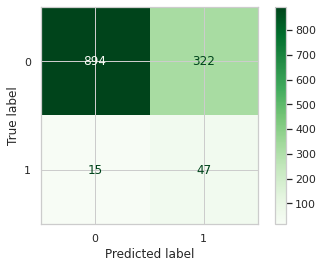



Random Forest :

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.12      0.16      0.14        62

    accuracy                           0.90      1278
   macro avg       0.54      0.55      0.54      1278
weighted avg       0.92      0.90      0.91      1278



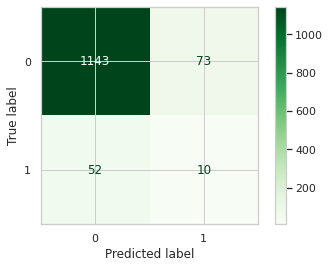



Decision Tree :

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1216
           1       0.12      0.23      0.16        62

    accuracy                           0.88      1278
   macro avg       0.54      0.57      0.55      1278
weighted avg       0.92      0.88      0.90      1278



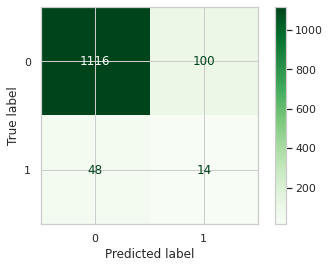



KNeighbors :

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1216
           1       0.09      0.32      0.15        62

    accuracy                           0.82      1278
   macro avg       0.53      0.58      0.52      1278
weighted avg       0.92      0.82      0.86      1278



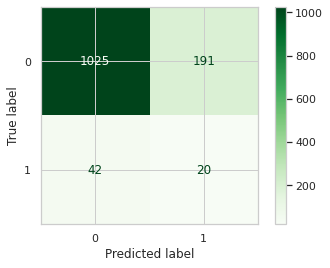



ADA Boost :

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1216
           1       0.13      0.68      0.21        62

    accuracy                           0.76      1278
   macro avg       0.55      0.72      0.54      1278
weighted avg       0.94      0.76      0.83      1278



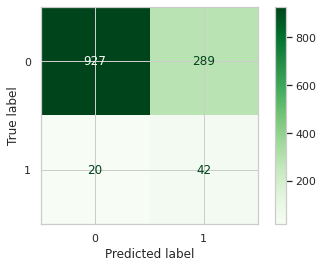



LightGBM :

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1216
           1       0.12      0.11      0.12        62

    accuracy                           0.92      1278
   macro avg       0.54      0.54      0.54      1278
weighted avg       0.91      0.92      0.92      1278



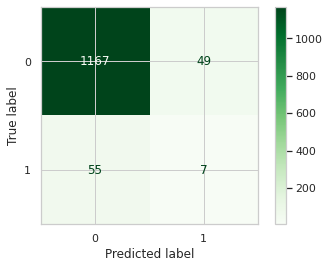



XGBoost :

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1216
           1       0.15      0.60      0.24        62

    accuracy                           0.82      1278
   macro avg       0.56      0.71      0.57      1278
weighted avg       0.94      0.82      0.87      1278



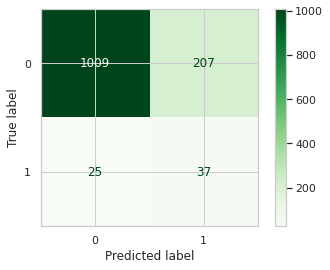



Gradient Boosting :

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1216
           1       0.16      0.56      0.25        62

    accuracy                           0.83      1278
   macro avg       0.57      0.71      0.58      1278
weighted avg       0.93      0.83      0.87      1278



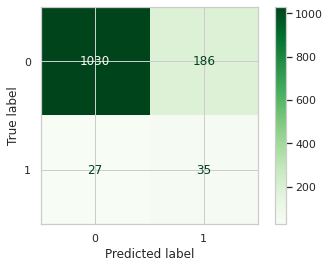

In [75]:
for model in range(len(models)):
  current_model = models[model][1]
  smote_model = smote_pipe(preprocessor, smote, current_model)
  smote_model.fit(X_train, y_train)
  y_pred = smote_model.predict(X_test)
  cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens');
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)


  print(models[model][0], ':\n')
  print(classification_report(y_test, y_pred))
  cm
  plt.show();
  print('\n')

# Model Tuning

- With the confusion matrixes that are displayed: I'm looking to see which models have the highest true positive and the best recall for true positve.
- Logistic Regression has the highest number of True Positives (47) and the best recall score for true postives.
- The next model that has those qualities is ADABoost with 42 True Postives and a Postive Recall Score of 68%.
---


In [76]:
#Creating a copy that model tuning will be used for
mt_df = ml_df.copy()

In [77]:
mt_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##**Set Up Param Grids**

In [78]:
logreg = LogisticRegression()
adaboost = AdaBoostClassifier()

##**Logistic Regression Tuning**

In [79]:
logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression())
logreg_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [80]:
# Assigning parameters for Logistic Regression
lr_param_grid = {'logisticregression__solver': ['lbfgs'],
                 'logisticregression__class_weight': ['balanced']}

In [81]:
# Combined GridSearchCV and Pipelines
lr_pipe_gs = GridSearchCV(logreg_pipe, lr_param_grid)

lr_pipe_gs.fit(X_train_preprocessed, y_train)
print('Best Logistic Regression Parameters:')
best_lr_pipe = lr_pipe_gs.best_estimator_
print(f'Accuracy of Best LogReg Model is: {best_lr_pipe.score(X_test_preprocessed, y_test)}')

Best Logistic Regression Parameters:
Accuracy of Best LogReg Model is: 0.7323943661971831


##**Print Tuned LR Model**

In [82]:
print(accuracy_score(y_test, y_pred))

0.8333333333333334


---
##**AdaBoost Tuning**

In [83]:
ada_pipe = make_pipeline(AdaBoostClassifier(n_estimators = 100))
ada = AdaBoostClassifier(n_estimators = 100)
ada.fit(X_train_preprocessed,y_train)

AdaBoostClassifier(n_estimators=100)

##**Print Tuned AdaBoost Model**

In [84]:
# Tuned AdaBoost train score
ada.score(X_train_preprocessed, y_train)

0.9525052192066806

In [85]:
# Tuned Adaboost test score
ada.score(X_test_preprocessed, y_test)

0.9475743348982786

---
##**Results**

- From this assessment, the final model I will be using is the **tuned AdaBoost Model** because it has a accuracy score of .95 for the training data and .94 for the testing data.

---
##**Input PCA Into Best Model**

In [86]:
# Instantiate PCA
pca_model_transformer = PCA(n_components=.95)

In [87]:
# Make pipeline that includes PCA & fit onto preprocessed training data
ada_pca_pipe = make_pipeline(pca_model_transformer, ada)
ada_pca_pipe.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('adaboostclassifier', AdaBoostClassifier(n_estimators=100))])

In [88]:
pred_ada_pca = ada_pca_pipe.predict(X_test_preprocessed)
print(classification_report(y_test, pred_ada_pca))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.33      0.08      0.13        62

    accuracy                           0.95      1278
   macro avg       0.64      0.54      0.55      1278
weighted avg       0.92      0.95      0.93      1278



- When the tuned AdaBoost Model uses PCA, the model is much worse because the recall score for the true postive labels is staggeringly low at 0.08.

---
#**Final Model & Justification**

- The final model that is chosen for this dataset and I would suggest for "production" is the **Tuned AdaBoost Classifier** because after changing some of the hyperparameters it made the model better by giving an overall better accuracy for both the true negatives and true positives.
- The accuracy when the model was tuned was almost 100% accurate with the tuned training data being 95% accurate and the testing data being 94% accurate.
- While in every model that was tested, there was going to be false negatives and false postives, but after careful consideration and evaluation the AdaBoost Model showed it could produce with the lowest rate for both.